In [1]:
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dropout
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Using InpactorDB with negative class

In [2]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redudant.fasta.kmers'
training_data = pd.read_csv(filename)
filename=None

In [3]:
path_log_base = './logs'
# class distribution
print(training_data.groupby('Label').size())

Label
1     12031
3      1458
4      1827
8        84
9      3556
12     6180
13     3130
14     2136
16      549
17     4532
18    10396
19     3499
20    17927
dtype: int64


In [4]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

training_data=None

print(label_vectors)
print(feature_vectors)

[18 18 18 ... 12 18 12]
[[2592 1965 1269 ...    4    0    0]
 [2959 2249 1811 ...    0    0    0]
 [5673 3949 3563 ...    8    4    3]
 ...
 [1939  906 1146 ...    4    8    6]
 [3071 1904 1979 ...    4    1    1]
 [1422  696 1208 ...    1    1    1]]


In [5]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None

from joblib import dump, load
dump(scaler, '/home/bioml/Projects/PhD/OE2/full_DL_version/std_scaler2.bin', compress=True)

['/home/bioml/Projects/PhD/OE2/full_DL_version/std_scaler2.bin']

In [6]:
pca = decomposition.PCA(n_components=0.96 ,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)
dump(pca, '/home/bioml/Projects/PhD/OE2/full_DL_version/std_pca2.bin', compress=True)

['/home/bioml/Projects/PhD/OE2/full_DL_version/std_pca2.bin']

In [7]:
print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

2261
(53844, 2261)


In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def metrics(Y_validation,predictions):
    classes = len(np.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2261)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               452400    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               600   

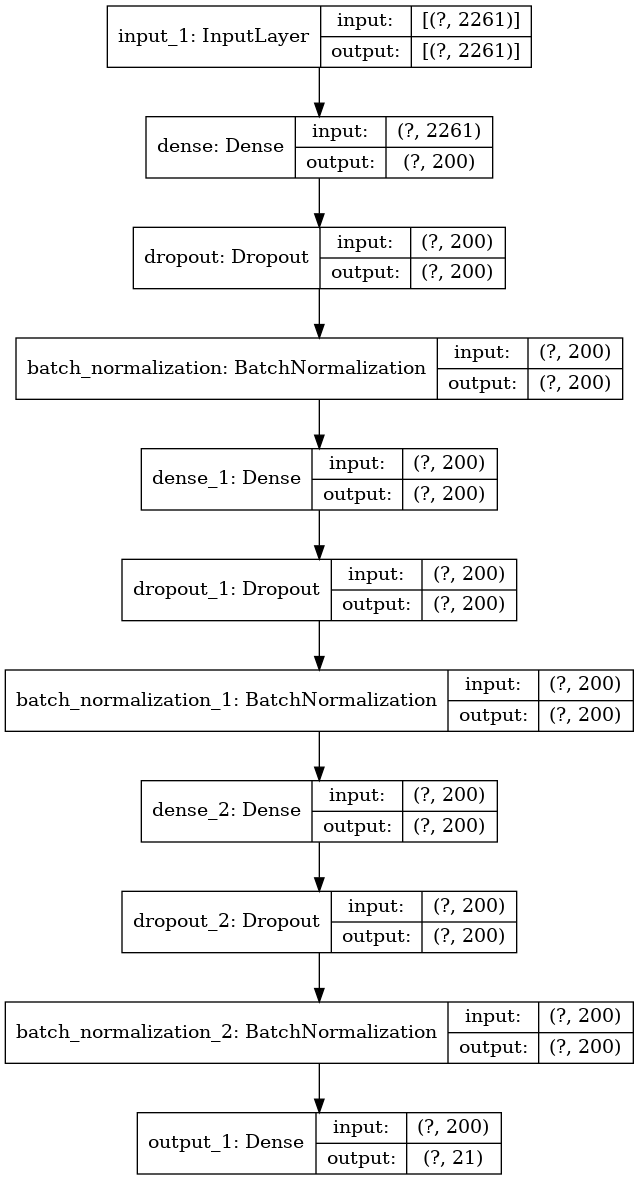

In [14]:
# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model

train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "Nakano1")
Final_Results_Test(log_Dir) 

Epoch 1/200
421/421 [==============================] - 2s 4ms/step - loss: 2.3891 - f1_m: 0.6797 - val_loss: 1.3212 - val_f1_m: 0.9609
Epoch 2/200
421/421 [==============================] - 2s 4ms/step - loss: 1.2569 - f1_m: 0.9263 - val_loss: 0.9909 - val_f1_m: 0.9756
Epoch 3/200
421/421 [==============================] - 2s 4ms/step - loss: 0.9929 - f1_m: 0.9505 - val_loss: 0.8652 - val_f1_m: 0.9769
Epoch 4/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8860 - f1_m: 0.9577 - val_loss: 0.8039 - val_f1_m: 0.9778
Epoch 5/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8388 - f1_m: 0.9599 - val_loss: 0.7814 - val_f1_m: 0.9797
Epoch 6/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8193 - f1_m: 0.9617 - val_loss: 0.7488 - val_f1_m: 0.9815
Epoch 7/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7953 - f1_m: 0.9621 - val_loss: 0.7352 - val_f1_m: 0.9832
Epoch 8/200
421/421 [==============================] - 

421/421 [==============================] - 2s 4ms/step - loss: 0.7738 - f1_m: 0.9699 - val_loss: 0.7240 - val_f1_m: 0.9857
Epoch 62/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7628 - f1_m: 0.9712 - val_loss: 0.7065 - val_f1_m: 0.9844
Epoch 63/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7735 - f1_m: 0.9701 - val_loss: 0.7350 - val_f1_m: 0.9844
Epoch 64/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7775 - f1_m: 0.9699 - val_loss: 0.7219 - val_f1_m: 0.9860
Epoch 65/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7640 - f1_m: 0.9696 - val_loss: 0.7094 - val_f1_m: 0.9846
Epoch 66/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7604 - f1_m: 0.9708 - val_loss: 0.7375 - val_f1_m: 0.9846
Epoch 67/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7736 - f1_m: 0.9700 - val_loss: 0.7452 - val_f1_m: 0.9849
Epoch 68/200
421/421 [==============================] - 2s 4m

421/421 [==============================] - 2s 4ms/step - loss: 0.7672 - f1_m: 0.9700 - val_loss: 0.7288 - val_f1_m: 0.9843
Epoch 122/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7724 - f1_m: 0.9705 - val_loss: 0.7342 - val_f1_m: 0.9866
Epoch 123/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7617 - f1_m: 0.9710 - val_loss: 0.7230 - val_f1_m: 0.9847
Epoch 124/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7614 - f1_m: 0.9709 - val_loss: 0.7202 - val_f1_m: 0.9854
Epoch 125/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7737 - f1_m: 0.9704 - val_loss: 0.7233 - val_f1_m: 0.9833
Epoch 126/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7598 - f1_m: 0.9701 - val_loss: 0.7366 - val_f1_m: 0.9837
Epoch 127/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7707 - f1_m: 0.9707 - val_loss: 0.7357 - val_f1_m: 0.9837
Epoch 128/200
421/421 [==============================] 

Epoch 181/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7632 - f1_m: 0.9708 - val_loss: 0.7328 - val_f1_m: 0.9854
Epoch 182/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7687 - f1_m: 0.9699 - val_loss: 0.7321 - val_f1_m: 0.9837
Epoch 183/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7698 - f1_m: 0.9706 - val_loss: 0.7432 - val_f1_m: 0.9826
Epoch 184/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7617 - f1_m: 0.9707 - val_loss: 0.7211 - val_f1_m: 0.9863
Epoch 185/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7631 - f1_m: 0.9707 - val_loss: 0.7180 - val_f1_m: 0.9847
Epoch 186/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7717 - f1_m: 0.9698 - val_loss: 0.7234 - val_f1_m: 0.9829
Epoch 187/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7637 - f1_m: 0.9704 - val_loss: 0.7375 - val_f1_m: 0.9841
Epoch 188/200
421/421 [==================

Loss=0.7270 y F1-Score=0.9866

saved-model-093-0.9849.hdf5
Loss=0.7237 y F1-Score=0.9862

saved-model-094-0.9839.hdf5
Loss=0.7021 y F1-Score=0.9867

saved-model-095-0.9846.hdf5
Loss=0.7250 y F1-Score=0.9866

saved-model-096-0.9865.hdf5
Loss=0.7195 y F1-Score=0.9859

saved-model-097-0.9847.hdf5
Loss=0.7106 y F1-Score=0.9882

saved-model-098-0.9834.hdf5
Loss=0.7204 y F1-Score=0.9848

saved-model-099-0.9851.hdf5
Loss=0.7305 y F1-Score=0.9860

saved-model-100-0.9847.hdf5
Loss=0.7108 y F1-Score=0.9855

saved-model-101-0.9837.hdf5
Loss=0.7227 y F1-Score=0.9861

saved-model-102-0.9850.hdf5
Loss=0.7354 y F1-Score=0.9857

saved-model-103-0.9859.hdf5
Loss=0.7149 y F1-Score=0.9864

saved-model-104-0.9833.hdf5
Loss=0.7323 y F1-Score=0.9836

saved-model-105-0.9845.hdf5
Loss=0.7390 y F1-Score=0.9874

saved-model-106-0.9842.hdf5
Loss=0.7226 y F1-Score=0.9872

saved-model-107-0.9844.hdf5
Loss=0.7084 y F1-Score=0.9858

saved-model-108-0.9853.hdf5
Loss=0.7506 y F1-Score=0.9852

saved-model-109-0.9841.hd

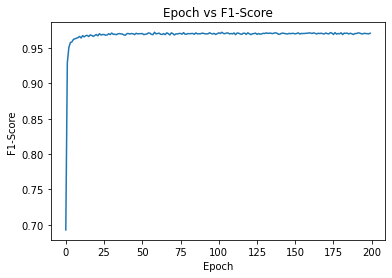

Test Accuracy 0.9883350729942322, Época:96

Test Accuracy 0.9881022572517395, Época:107

Test Accuracy 0.9880293607711792, Época:106

Test Accuracy 0.9878010749816895, Época:171

Test Accuracy 0.9877990484237671, Época:73

Test Accuracy 0.9877306222915649, Época:170

Test Accuracy 0.9876533150672913, Época:42

Test Accuracy 0.9876531958580017, Época:78

Test Accuracy 0.9875970482826233, Época:151

Test Accuracy 0.9874321222305298, Época:95


Train Accuracy 0.9724524617195129, Época:59

Train Accuracy 0.9724180102348328, Época:103

Train Accuracy 0.9719668626785278, Época:174

Train Accuracy 0.9719422459602356, Época:177

Train Accuracy 0.9719101786613464, Época:78

Train Accuracy 0.9717265367507935, Época:95

Train Accuracy 0.9716641902923584, Época:181

Train Accuracy 0.9716418981552124, Época:138

Train Accuracy 0.9716078639030457, Época:67

Train Accuracy 0.9715904593467712, Época:101


Validation F1-Score 0.9869588017463684, Época:107

Validation F1-Score 0.9863241910934448, Época:

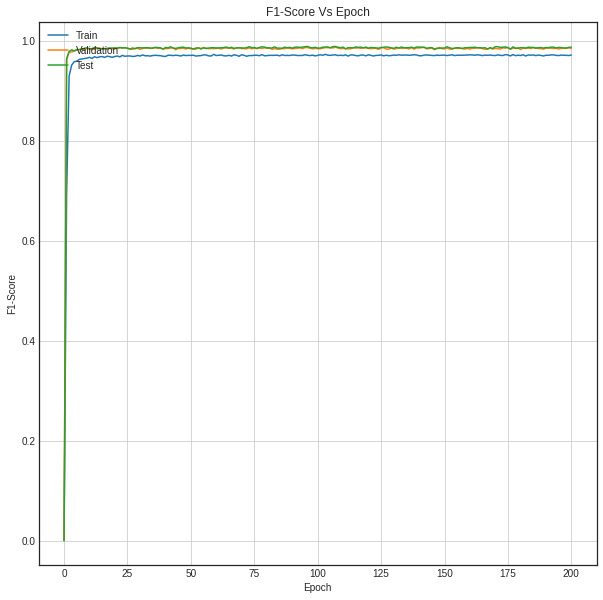

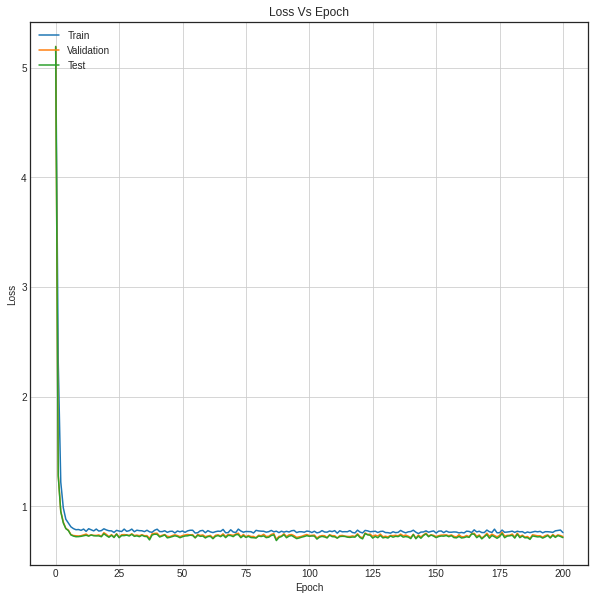

In [16]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 0.57%
Baseline Error dev: 1.42%
Baseline Error test: 1.17%
Accuracy: 0.9941869103335562
F1 score: 0.9935329555794922
Recall: 0.9941869103335562
Precision: 0.9928853008347751

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9563
           3       0.98      0.99      0.98      1158
           4       1.00      1.00      1.00      1481
           8       0.00      0.00      0.00        71
           9       0.99      0.99      0.99      2896
          12       0.98      0.99      0.98      5006
          13       1.00      1.00      1.00      2465
          14       0.99      0.99      0.99      1717
          16       1.00      0.99      1.00       434
          17       1.00      1.00      1.00      3605
          18       1.00      0.99      1.00      8282
          19       0.99      0.99      0.99      2765
          20       1.00      1.00      1.00     14401

    accuracy         

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaco

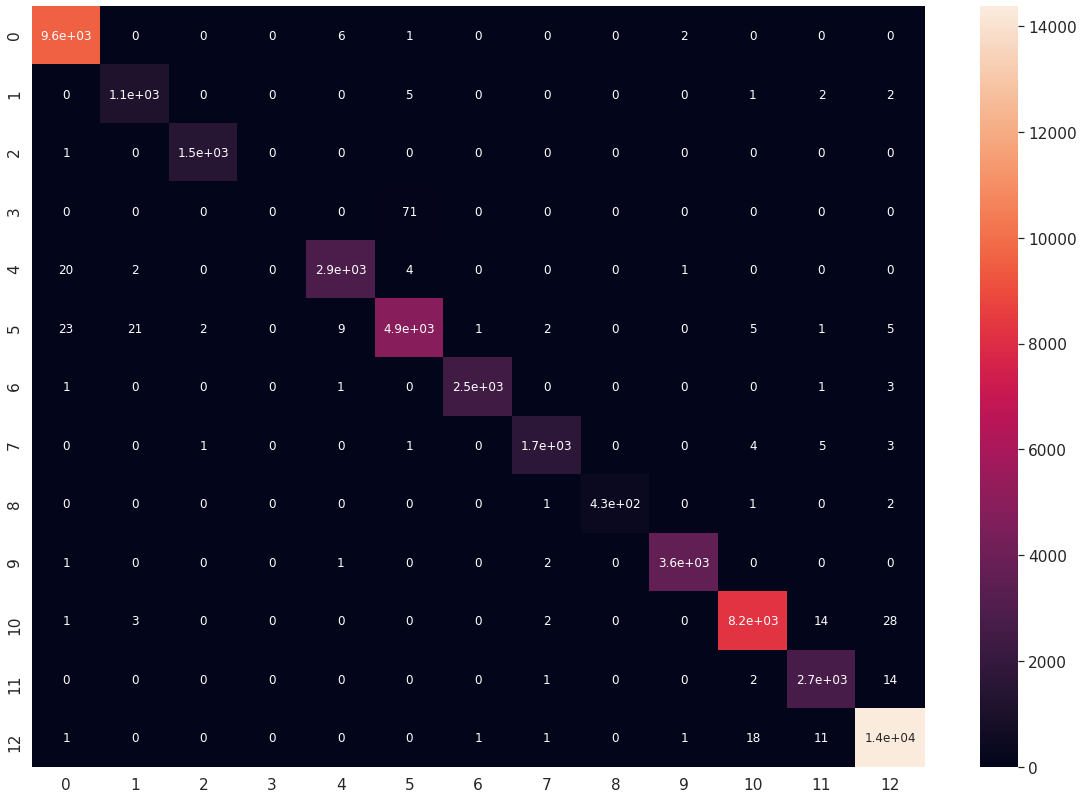

Accuracy: 0.9861812778603269
F1 score: 0.9857173354236556
Recall: 0.9861812778603269
Precision: 0.9853009268559317

 clasification report:
               precision    recall  f1-score   support

           1       0.98      1.00      0.99      1248
           3       0.97      0.98      0.98       155
           4       1.00      0.99      1.00       180
           8       0.00      0.00      0.00         6
           9       0.98      0.98      0.98       341
          12       0.98      0.96      0.97       599
          13       0.99      0.99      0.99       340
          14       0.99      0.97      0.98       218
          16       0.96      0.93      0.95        57
          17       0.98      1.00      0.99       430
          18       0.99      0.98      0.99      1055
          19       0.98      0.98      0.98       362
          20       0.99      0.99      0.99      1739

    accuracy                           0.99      6730
   macro avg       0.91      0.90      0.91     

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaco

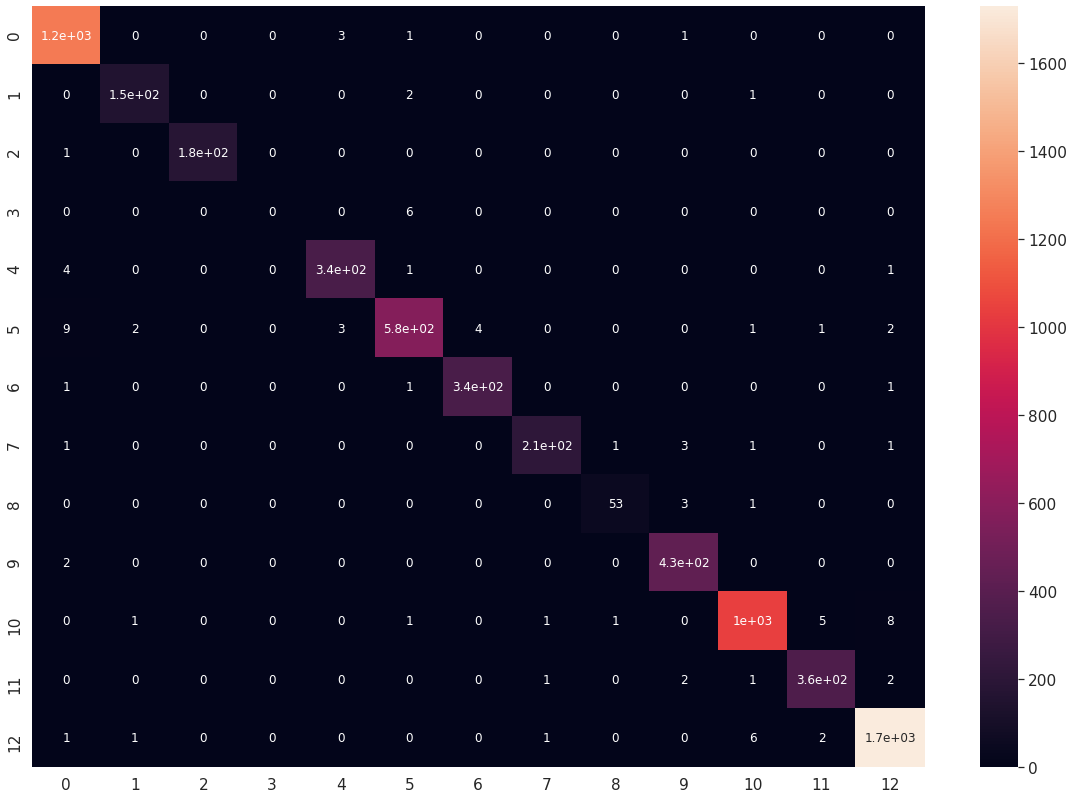

Accuracy: 0.98796612687565
F1 score: 0.9874406770405265
Recall: 0.98796612687565
Precision: 0.986967633576653

 clasification report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99      1220
           3       0.96      0.98      0.97       145
           4       1.00      0.98      0.99       166
           8       0.00      0.00      0.00         7
           9       0.98      0.98      0.98       319
          12       0.97      0.96      0.96       575
          13       1.00      0.98      0.99       325
          14       0.98      0.97      0.98       201
          16       0.98      0.95      0.96        58
          17       0.99      1.00      1.00       497
          18       0.99      0.99      0.99      1059
          19       0.97      1.00      0.99       372
          20       0.99      1.00      0.99      1787

    accuracy                           0.99      6731
   macro avg       0.91      0.91      0.91      6731

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaco

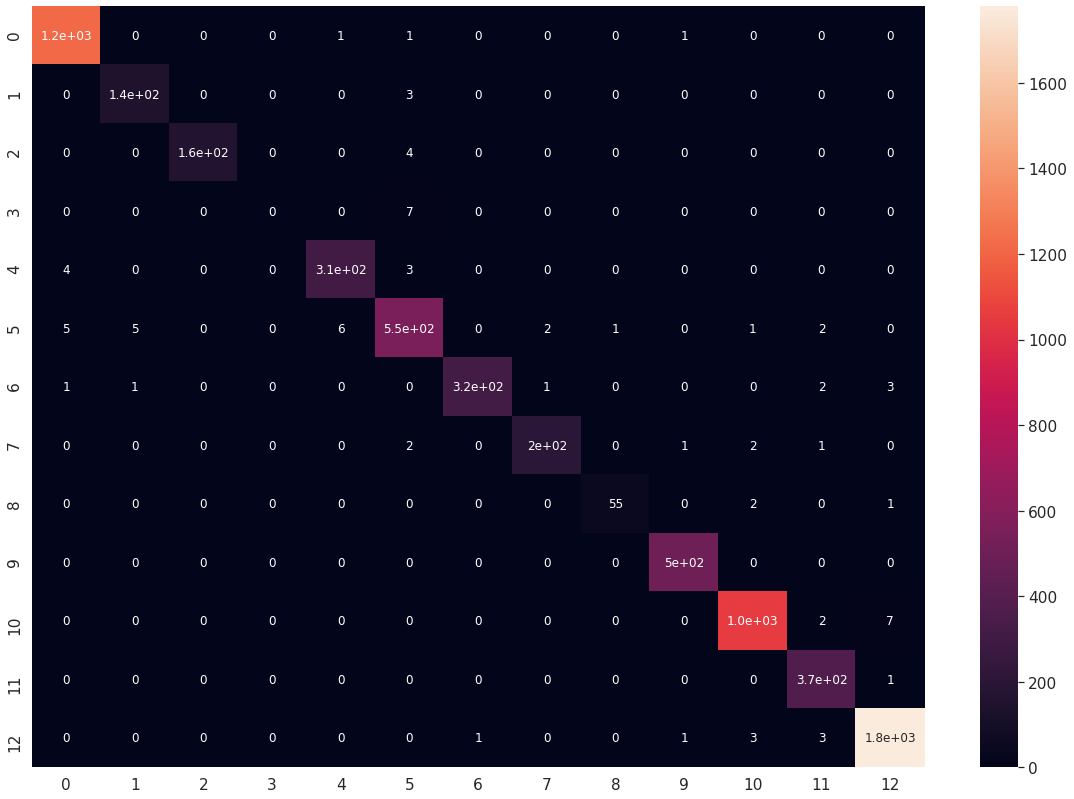

In [17]:
model = tf.keras.models.load_model(log_Dir+'/saved-model-096-0.9859.hdf5', custom_objects={'f1_m':f1_m})

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(Y_test, [argmax(x) for x in predictions])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
#plt.savefig(bbox_inches='tight',dpi=500)

print(average_precision_score(Y_test, predictions))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_test, [argmax(x) for x in predictions])
auc = roc_auc_score(Y_test, predictions)
print('AUC: %.3f' % auc)